In [3]:
#This notebook gets the centroid and label information of two different clustering models,
#locates the police station closer to the centroid of the clusters and calculates the
#response time of a drone traveling from its base to each of the crimes in its cluster.

In [1]:
import statistics

In [2]:
import numpy as np
import pandas as pd
import math
from operator import itemgetter

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Function that computes the distance between two points using their coordinates. Returns a distance in km.
def distancia_euc(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p) * math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p))/2
    d = 12742 * math.asin(math.sqrt(a))
    return  d

In [5]:
#Read police station locations
ubicaciones_seguridad = pd.read_csv('servicios_y_sedes_fgj.csv',encoding = "ISO-8859-1")
ubicaciones_limpio = ubicaciones_seguridad.loc[:,['sede','latitude','longitude']]

### kmedians

In [7]:
#Read json files with centroids
centroides_ideal = open('[PATH TO CENTROID JSON FILES]')
centroides_ideal = json.load(centroides_ideal)


In [8]:
# Find the new centroid.
centroides_desplazados = dict()
for k,centroides_ideal in centroides_final.items():
    centroides_ideal_df = pd.DataFrame(centroides_ideal)
    centroides_ideal_df = centroides_ideal_df.T
    min_vector_cluster = dict()
    for i in range(len(centroides_ideal_df)):
        punto_mas_cercano = 1000
        ubicacion_mas_cercana = [0,0]
        for cluster in range(len(ubicaciones_limpio)):
            distancia = distancia_euc(centroides_ideal_df.iloc[i,1], centroides_ideal_df.iloc[i,0], ubicaciones_limpio.loc[cluster,'latitude'], ubicaciones_limpio.loc[cluster,'longitude'])
            if distancia < punto_mas_cercano:
                punto_mas_cercano = distancia
                ubicacion_mas_cercana[0] = ubicaciones_limpio.loc[cluster,'longitude'], ubicaciones_limpio.loc[cluster,'latitude']   
        min_vector_cluster[i] = [ubicacion_mas_cercana[0],punto_mas_cercano]
    centroide_cluster = {k:v[0] for (k,v) in min_vector_cluster.items()}
    centroides_desplazados[k]= centroide_cluster

In [10]:
# Read the files with the model labels and compute all the distances from all the centroids to the crime locations.
dist_centroides_puntos = dict()

for n_k,centroide_cluster in centroides_desplazados.items():
    data_delitos_kmed = pd.read_csv("[PATH TO CLUSTER LABELS CSV FILES]{}.csv".format(n_k))
    X = data_delitos_kmed.loc[:,['longitud','latitud','kmedians_labels']]
    distancias_cluster = dict()

    for cluster in list(set(X['kmedians_labels'])):
            dist_list = []
            for i in zip(X[X['kmedians_labels']==cluster].loc[:,'longitud'],X[X['kmedians_labels']==cluster].loc[:,'latitud']):
                    dist_list.append(distancia_euc(centroide_cluster[cluster][1],centroide_cluster[cluster][0],i[1],i[0]))
            distancias_cluster[cluster] = dist_list
    dist_centroides_puntos[n_k] = distancias_cluster

In [11]:
#Compute the median of the response for each number of clusters.
resultados = dict()
for n_k,cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in cluster:
        lista_distancias = lista_distancias + cluster[i]
    resultados[n_k]= statistics.median(lista_distancias)

In [12]:
#Transform results from distance to time.
resultados_tiempos = {int(k):(((v/61.2)*3600)+10) for k,v in resultados.items()}

Text(0, 0.5, 'Response time (seconds)')

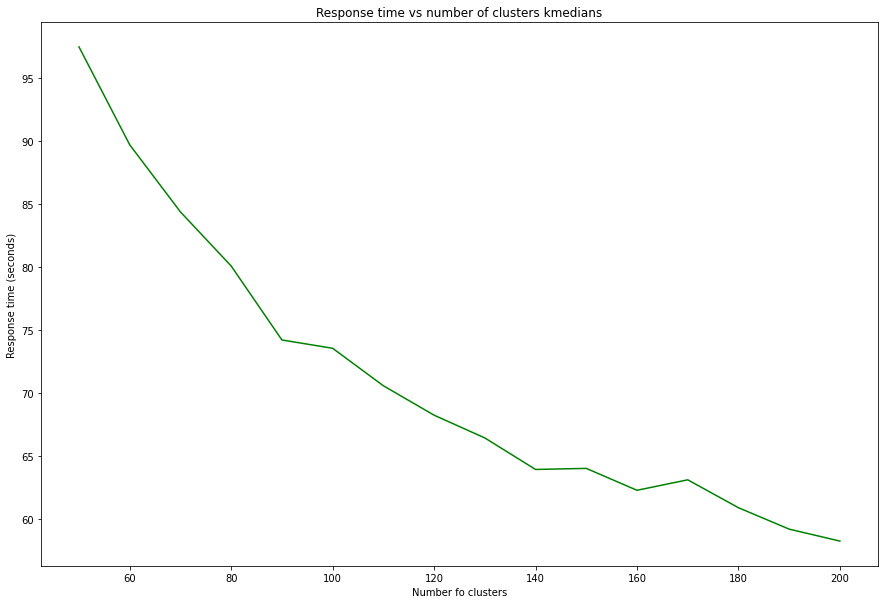

In [13]:
#Plot time vs number of clusters.
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos.keys()),list(resultados_tiempos.values()),color='green')
plt.title('Response time vs number of clusters kmedians')
plt.xlabel('Number fo clusters')
plt.ylabel('Response time (seconds)')

In [14]:
# Compute the response time with a 95% confidence interval for each n_k.
resultados_95 = dict()
for n_k,radio_cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in radio_cluster.values():
        lista_distancias = lista_distancias + i
    perc_95 = np.percentile(lista_distancias,95)
    radio_max = 0
    for radio in lista_distancias:
        if radio <= perc_95 and radio > radio_max:
            radio_max = radio
    resultados_95[n_k]= radio_max

In [15]:
# Transform results from distance to time.
resultados_tiempos_95 = {int(k):(((v/61.2)*3600)+10) for k,v in resultados_95.items()}

Text(0, 0.5, 'Response time (seconds)')

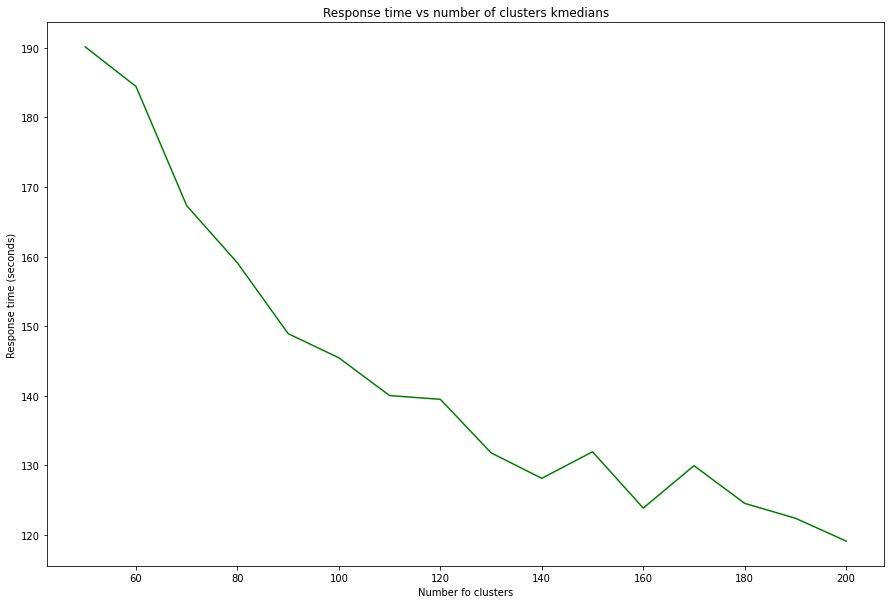

In [17]:
# Plot time vs number of clusters.
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos_95.keys()),list(resultados_tiempos_95.values()),color='green')
plt.title('Response time vs number of clusters kmedians')
plt.xlabel('Number fo clusters')
plt.ylabel('Response time (seconds)')

### fcmeans

In [19]:
#Read json files with centroids
centroides_ideal = open('[PATH TO CENTROID JSON FILES]')
centroides_ideal = json.load(centroides_ideal)

# Find the new centroid.
centroides_desplazados = dict()
for k,centroides_ideal in centroides_final.items():
    centroides_ideal_df = pd.DataFrame(centroides_ideal)
    centroides_ideal_df = centroides_ideal_df.T
    min_vector_cluster = dict()
    for i in range(len(centroides_ideal_df)):
        punto_mas_cercano = 1000
        ubicacion_mas_cercana = [0,0]
        for cluster in range(len(ubicaciones_limpio)):
            distancia = distancia_euc(centroides_ideal_df.iloc[i,1], centroides_ideal_df.iloc[i,0], ubicaciones_limpio.loc[cluster,'latitude'], ubicaciones_limpio.loc[cluster,'longitude'])
            if distancia < punto_mas_cercano:
                punto_mas_cercano = distancia
                ubicacion_mas_cercana[0] = ubicaciones_limpio.loc[cluster,'longitude'], ubicaciones_limpio.loc[cluster,'latitude']   
        min_vector_cluster[i] = [ubicacion_mas_cercana[0],punto_mas_cercano]
    centroide_cluster = {k:v[0] for (k,v) in min_vector_cluster.items()}
    centroides_desplazados[k]= centroide_cluster

# Compute all the distances from all the centroids to the crime locations.
dist_centroides_puntos = dict()

for n_k,centroide_cluster in centroides_desplazados.items():
    data_delitos_kmed = pd.read_csv("[PATH TO CLUSTER LABELS CSV FILES]{}.csv".format(n_k))
    X = data_delitos_kmed.loc[:,['longitud','latitud','fcm_labels']]
    distancias_cluster = dict()

    for cluster in list(set(X['fcm_labels'])):
            dist_list = []
            for i in zip(X[X['fcm_labels']==cluster].loc[:,'longitud'],X[X['fcm_labels']==cluster].loc[:,'latitud']):
                    dist_list.append(distancia_euc(centroide_cluster[cluster][1],centroide_cluster[cluster][0],i[1],i[0]))
            distancias_cluster[cluster] = dist_list
    dist_centroides_puntos[n_k] = distancias_cluster

#Calcular la mediana de la respuesta para cada número clústeres.
resultados = dict()
for n_k,cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in cluster:
        lista_distancias = lista_distancias + cluster[i]
    resultados[n_k]= statistics.median(lista_distancias)

#Transform results from distance to time.
resultados_tiempos = {int(k):(((v/61.2)*3600)+10) for k,v in resultados.items()}

Text(0, 0.5, 'Response time (seconds)')

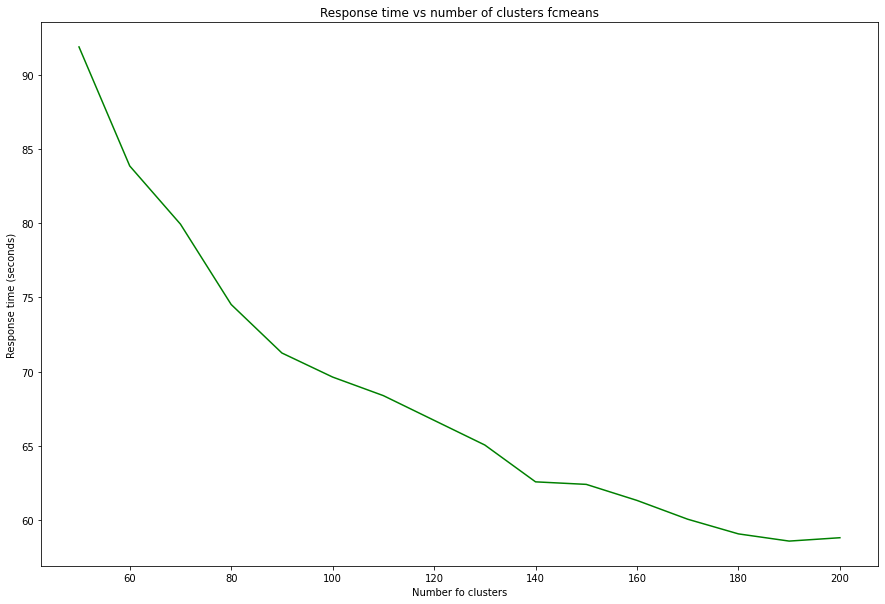

In [21]:
#Plot time vs number of clusters.
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos.keys()),list(resultados_tiempos.values()),color='green')
plt.title('Response time vs number of clusters fcmeans')
plt.xlabel('Number fo clusters')
plt.ylabel('Response time (seconds)')

Text(0, 0.5, 'Response time (seconds)')

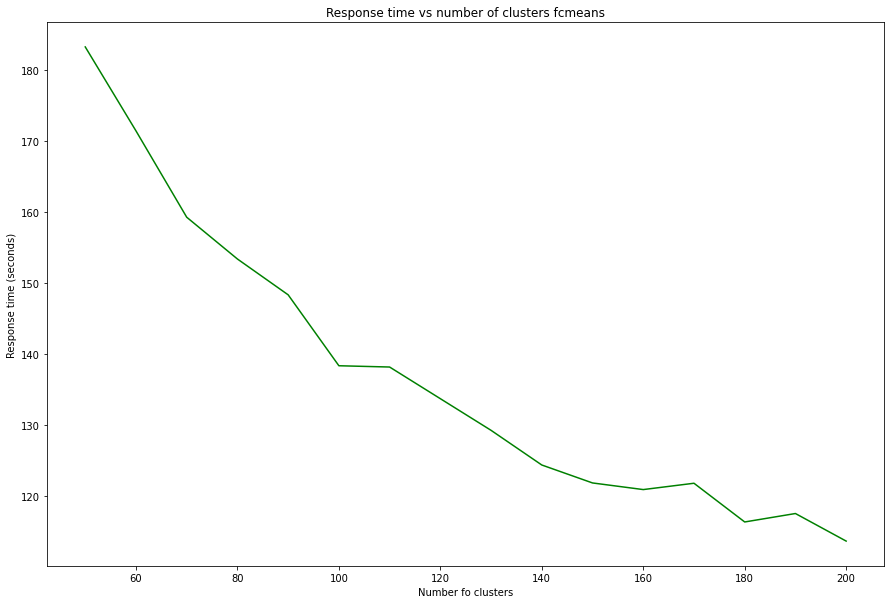

In [22]:
# Compute the response time with a 95% confidence interval for each n_k.
resultados_95 = dict()
for n_k,radio_cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in radio_cluster.values():
        lista_distancias = lista_distancias + i
    perc_95 = np.percentile(lista_distancias,95)
    radio_max = 0
    for radio in lista_distancias:
        if radio <= perc_95 and radio > radio_max:
            radio_max = radio
    resultados_95[n_k]= radio_max

#Transform results from distance to time.
resultados_tiempos_95 = {int(k):(((v/61.2)*3600)+10) for k,v in resultados_95.items()}

#Plot time vs number of clusters.
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos_95.keys()),list(resultados_tiempos_95.values()),color='green')
plt.title('Response time vs number of clusters fcmeans')
plt.xlabel('Number fo clusters')
plt.ylabel('Response time (seconds)')